In [1]:
import pandas as pd
import numpy as np
import datetime
import talib
import matplotlib.pyplot as plt
from wmpy.conf.settings import product_info_df, trade_days_list
from wmpy.trader.utility import get_previous_date, load_bar, load_bar_period, get_commission, map_parallel, get_trading_days, get_main_contract, read_sql_bar, get_symbol_name, np_shift, update_main_contract, get_main_contract_from_json
from wmpy.app.cta_backtester.backtesting_bar import cal_all_pnl, cal_daily_pnl # 注意这里是backtesting_bar

In [2]:
#过滤掉非交易时间
def bar_filter(bar_df, contract=None):
    def is_trading_time(dt):
        condition = (
            (dt.time() >= datetime.time(9, 0) and dt.time() < datetime.time(11, 30))    # 上午
         or (dt.time() >= datetime.time(13, 0) and dt.time() < datetime.time(15, 0))  # 下午
         or (dt.time() >= datetime.time(21, 0) and dt.time() < datetime.time(23, 0)))   # 夜盘
        return condition
    bool_list = [is_trading_time(x) for x in bar_df.index]
    return bar_df.loc[bool_list].copy()

In [3]:
#查看期货品种
import qgrid
qgrid.show_grid(product_info_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
# hp滤波
def hp(x, lamb = 50):
    def D_matrix(N):
        D = np.zeros((N-1,N))
        D[:,1:] = np.eye(N-1)
        D[:,:-1] -= np.eye(N-1)
        """D1
        [[-1.  1.  0. ...  0.  0.  0.]
         [ 0. -1.  1. ...  0.  0.  0.]
         [ 0.  0. -1. ...  0.  0.  0.]
         ...
         [ 0.  0.  0. ...  1.  0.  0.]
         [ 0.  0.  0. ... -1.  1.  0.]
         [ 0.  0.  0. ...  0. -1.  1.]]
        """
        return D
    N = len(x)
    D1 = D_matrix(N)
    D2 = D_matrix(N-1)
    D = D2 @ D1
    y = np.linalg.inv((np.eye(N)+lamb*D.T@D))@ x
    return y[-1]

In [5]:
# Fourier滤波
def Fourier_filter(x,k=50):
    y = np.fft.fft(x)
    y[k:] = 0
    x_ = np.fft.ifft(y)
    res = []
    for i in range(len(x_)):
        res.append(x_[i].real)
    return res[-1]

In [6]:
from wmpy.trader.utility import update_main_contract, get_main_contract_from_json
date = 20201231
contract = 'rb2105' # 当天的主力合约

In [7]:
bar_df = load_bar(contract, date)
bar_df = bar_filter(bar_df) # 过滤非交易时间（最后一分钟虽然有行情，但无法交易，含有的信息量也很少）
bar_df

,contract,exchange,interval,volume,open_interest,open_price,high_price,low_price,close_price,bid_price_1,ask_price_1
datetime,,,,,,,,,,,
2020-12-30 21:00:00,rb2105,SHFE,1m,29260.0,1183578.0,4257.0,4263.0,4254.0,4263.0,4257.0,4259.0
2020-12-30 21:01:00,rb2105,SHFE,1m,22412.0,1184489.0,4264.0,4264.0,4258.0,4258.0,4263.0,4264.0
2020-12-30 21:02:00,rb2105,SHFE,1m,16091.0,1185280.0,4258.0,4266.0,4256.0,4265.0,4258.0,4259.0
2020-12-30 21:03:00,rb2105,SHFE,1m,21586.0,1184805.0,4265.0,4274.0,4265.0,4271.0,4265.0,4266.0
2020-12-30 21:04:00,rb2105,SHFE,1m,12940.0,1184325.0,4272.0,4276.0,4271.0,4272.0,4271.0,4272.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:55:00,rb2105,SHFE,1m,14902.0,1219791.0,4370.0,4378.0,4366.0,4377.0,4369.0,4370.0
2020-12-31 14:56:00,rb2105,SHFE,1m,24563.0,1221455.0,4377.0,4386.0,4375.0,4385.0,4376.0,4377.0
2020-12-31 14:57:00,rb2105,SHFE,1m,14739.0,1219919.0,4384.0,4389.0,4383.0,4384.0,4384.0,4385.0


In [8]:
# 转化为等volume区间，每经过同样的volume间隔更新一次价格。
temp_df = bar_df.copy()
v_interval = 20000
window = 100
temp_df['cumsum_v'] = temp_df['volume'].cumsum()
bins = [0]
for i in range(1,len(temp_df)+1):
    bins.append(v_interval*i)
labels = np.arange(len(temp_df))
temp_df['category'] = pd.cut(temp_df['cumsum_v'],bins=bins,labels=labels)
temp_df['price_v'] = 0
temp_df['price_v'][0] = temp_df['close_price'][0]
for i in range(1,len(temp_df)):
    if temp_df['category'][i] != temp_df['category'][i-1]:
        temp_df['price_v'][i] = temp_df['close_price'][i]
    else:
        temp_df['price_v'][i] = temp_df['price_v'][i-1]
temp_df['hp_filter'] = temp_df['price_v'].rolling(window).apply(hp,args=(1000,))
temp_df['Fourier_filter'] = temp_df['price_v'].rolling(window).apply(Fourier_filter,args=(3,))

/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [9]:
temp_df

,contract,exchange,interval,volume,open_interest,open_price,high_price,low_price,close_price,bid_price_1,ask_price_1,cumsum_v,category,price_v,hp_filter,Fourier_filter
datetime,,,,,,,,,,,,,,,,
2020-12-30 21:00:00,rb2105,SHFE,1m,29260.0,1183578.0,4257.0,4263.0,4254.0,4263.0,4257.0,4259.0,29260.0,1,4263,NaN,NaN
2020-12-30 21:01:00,rb2105,SHFE,1m,22412.0,1184489.0,4264.0,4264.0,4258.0,4258.0,4263.0,4264.0,51672.0,2,4258,NaN,NaN
2020-12-30 21:02:00,rb2105,SHFE,1m,16091.0,1185280.0,4258.0,4266.0,4256.0,4265.0,4258.0,4259.0,67763.0,3,4265,NaN,NaN
2020-12-30 21:03:00,rb2105,SHFE,1m,21586.0,1184805.0,4265.0,4274.0,4265.0,4271.0,4265.0,4266.0,89349.0,4,4271,NaN,NaN
2020-12-30 21:04:00,rb2105,SHFE,1m,12940.0,1184325.0,4272.0,4276.0,4271.0,4272.0,4271.0,4272.0,102289.0,5,4272,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 14:55:00,rb2105,SHFE,1m,14902.0,1219791.0,4370.0,4378.0,4366.0,4377.0,4369.0,4370.0,2551371.0,127,4377,4370.603942,4345.377228
2020-12-31 14:56:00,rb2105,SHFE,1m,24563.0,1221455.0,4377.0,4386.0,4375.0,4385.0,4376.0,4377.0,2575934.0,128,4385,4375.152781,4346.596275
2020-12-31 14:57:00,rb2105,SHFE,1m,14739.0,1219919.0,4384.0,4389.0,4383.0,4384.0,4384.0,4385.0,2590673.0,129,4384,4378.740926,4347.557632


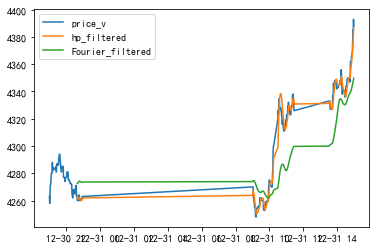

In [10]:
plt.plot(temp_df['price_v'], label='price_v')
plt.plot(temp_df['hp_filter'], label='hp_filtered')
plt.plot(temp_df['Fourier_filter'], label='Fourier_filtered')
plt.legend()
plt.show()

In [11]:
# 基于HP滤波和Fourier滤波的策略
# 可以发现当HP滤波后的均线上穿Fourier滤波后的均线时，价格上突，开仓做多
# 当HP滤波后的均线下穿Fourier滤波后的均线时，价格下突，开仓做空
def HF_strategy(bar_df, date, contract, parameter_dict=None):
    LAMB = parameter_dict['LAMB']
    FOURIER_K = parameter_dict['FOURIER_K']
    WINDOW = parameter_dict['WINDOW']
    V_INTERVAL = parameter_dict['V_INTERVAL']
    
    start_date = get_previous_date(date, 2)
    end_date = date
    data_df = load_bar_period(contract, start_date, end_date)
    data_df = bar_filter(data_df)
    
    temp_df = data_df.copy()   # 防止改掉原数据，引起不必要的bug
    temp_df['cumsum_v'] = temp_df['volume'].cumsum()
    bins = [0]
    for i in range(1,len(temp_df)+1):
        bins.append(V_INTERVAL*i)
    labels = np.arange(len(temp_df))
    temp_df['category'] = pd.cut(temp_df['cumsum_v'],bins=bins,labels=labels)
    temp_df['price_v'] = 0
    temp_df['price_v'][0] = temp_df['close_price'][0]
    for i in range(1,len(temp_df)):
        if temp_df['category'][i] != temp_df['category'][i-1]:
            temp_df['price_v'][i] = temp_df['close_price'][i]
        else:
            temp_df['price_v'][i] = temp_df['price_v'][i-1]
    temp_df['hp_filter'] = temp_df['price_v'].rolling(WINDOW).apply(hp,args=(LAMB,))
    temp_df['Fourier_filter'] = temp_df['price_v'].rolling(WINDOW).apply(Fourier_filter,args=(FOURIER_K,))

    def _cal_signal(x):
            hp = x['hp_filter']
            Fourier = x['Fourier_filter']

            if pd.isna(hp) or pd.isna(Fourier):    # 如果任意一个值为空
                signal = 0
            elif hp >= Fourier:
                signal = 1
            else:
                signal = -1
            return signal

    temp_df['signal'] = temp_df.apply(_cal_signal, axis=1) # 对temp_df的每一行做判断
    temp_df['position'] = temp_df['signal'].shift(1)       # 根据上一分钟的信号决定仓位
    temp_df = pd.DataFrame(temp_df, index=bar_df.index)
    signal_ser = temp_df['signal'].copy()
    position_ser = temp_df['position'].copy()
    
    # 过滤掉夜盘的信号，防止隔夜持仓，也防止加班盯盘
    if len(np.unique(bar_df.index.date)) > 1:
        current_date = bar_df.index[-1].date()
        # 以凌晨3点位分界，划分夜盘和日盘
        split_time = datetime.datetime.combine(current_date, datetime.time(3, 0))

        night_end_time = bar_df[:split_time].index[-1]
        day_start_time = bar_df[split_time:].index[0]
        signal_ser.loc[:night_end_time] = 0


    ## 返回这段时间的持仓序列
    position_ser.iloc[0] = 0
    position_ser.iloc[-1] = 0
    position_ser.iloc[-2] = 0
    position_ser.iloc[-3] = 0
    
    return position_ser

In [14]:
# 网格搜索调整参数
best_score = -10000
for lamb in [10,100,1000]:
    for k in [5,10]:
        for v_interval in [10000,20000,30000]:
            # 对于每种参数可能的组合，进行一次训练
            parameter_dict = dict(WINDOW = 100, V_INTERVAL = v_interval, LAMB = lamb, FOURIER_K = k)
            df = cal_all_pnl(20200901, 20201231, HF_strategy, parameter_dict, symbol='rb', contract=None, mode='take', commission='yesterday', rebate=0, bar_filter=bar_filter, workers=None, verbose=False)
            df.loc[datetime.date(2020, 12, 21)] = 0, 0, 0, 0, 0
            score = df['net_pnl'].sum()
            # 找到表现最好的参数
            if score > best_score:
                best_score = score
                best_parameters = dict(WINDOW = 100, V_INTERVAL = v_interval, LAMB = lamb, FOURIER_K = k)

/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
best_parameters

{'WINDOW': 100, 'V_INTERVAL': 30000, 'LAMB': 1000, 'FOURIER_K': 10}

In [16]:
best_parameters = dict(WINDOW = 100, V_INTERVAL = 20000,LAMB = 1000, FOURIER_K = 3)
df = cal_all_pnl(20200901, 20210228, HF_strategy, best_parameters, symbol='rb', contract=None, mode='take', commission='yesterday', rebate=0, bar_filter=bar_filter, workers=None, verbose=True)

  0%|          | 0/117 [00:00<?, ?it/s]/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/jupyterhub_py_3_7_5/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [17]:
df

,total_pnl,net_pnl,commission,num,holding_period
2020-09-01,-37.0,-46.0611,9.0611,12.0,342.0
2020-09-02,-15.0,-20.2827,5.2827,7.0,342.0
2020-09-03,35.0,31.9655,3.0345,4.0,342.0
2020-09-04,-5.0,-12.5387,7.5387,10.0,342.0
2020-09-07,-24.0,-31.5112,7.5112,10.0,342.0
...,...,...,...,...,...
2021-02-22,67.0,59.7071,7.2929,8.0,342.0
2021-02-23,46.0,41.4094,4.5906,5.0,342.0
2021-02-24,-105.0,-114.1467,9.1467,10.0,342.0
2021-02-25,7.0,1.3983,5.6017,6.0,342.0


------------------------------
交易天数：	117
区间收益：	-716.31
日度胜率：	41.03%
日盈亏比：	1.03:1
------------------------------
最大回撤：	954.68
回撤起始：	2020-09-10
回撤结束：	2020-12-07
------------------------------
交易次数：	893.0
每日平均：	7.63
每笔收益：	-0.80
------------------------------
信息比率：	-0.13
------------------------------


(-716.3137999999512,
 954.680199999968,
 -0.802143113101849,
 893.0,
 117,
 -0.12645066116808645)

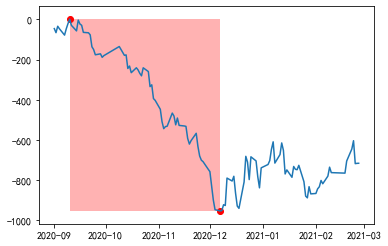

In [18]:
from wmpy.trader.utility import performance_summary
performance_summary(df, key='net_pnl', _plot=True, _print=True)

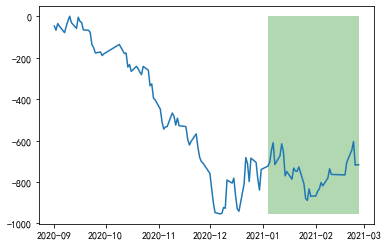

In [19]:
# 20210101后为样本外数据
value_ser = df['net_pnl'].cumsum()
value_ser.plot()
plt.fill_between(value_ser[datetime.date(2021, 1, 1):].index,
                         value_ser.min(),
                         value_ser.max(),
                         facecolor='green',
                         alpha=0.3)